##fMRI 1st level (Individual) analysis
Individual (1st level) analysis -adapted from nipype tutorial (Miykael Notters and Gi Lio examples)

In this analysis workflow we will:
* Extract stimuli time from json files (BIDs)
* Specify the 1st level GLM (General Linear Model)
* Specify Contrasts to compute
* Estimate contrasts (in this example: con_0001:NF vs REST [0 1], con_0002 NF>REST [-1 1]
* Normalize contrasts


##Imports

In [ ]:
!pip install nipype
!pip install nilearn
!pip install bids

In [ ]:
from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast, Normalize12
tpm_img ='/home/ubuntu/Documents/MATLAB/spm12/tpm/TPM.nii' # normalization template

from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
from bids.layout import BIDSLayout
from nipype.algorithms.misc import Gunzip

import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat

##Experiments parameters
(get metadata from BIDs json files)


In [ ]:
data_dir='/home/ubuntu/Documents/BIDs/XP2'
experiment_dir='/home/ubuntu/Documents/windowshare/output/XP2'
output_dir='datasink'
working_dir='workingdir'

subject_list=['xp204','xp205','xp210','xp212','xp213','xp215','xp216','xp217','xp221','xp223']
#subject_list_1D=['xp201',xp202','xp203','xp206','xp208','xp209','xp211','xp214','xp218','xp219','xp220','xp222']

task_list=['1dNF']
run_list=['01','02','03']
fwhm=[6]

#FIND INFO FROM BIDS LAYOUT
func_file='/home/ubuntu/Documents/BIDs/XP2/sub-%s/func/sub-%s_task-%s_run-%s_bold.nii.gz' % (subject_list[0],subject_list[0],task_list[0],run_list[0])
layout_data=BIDSLayout(data_dir)
#sub_list=layout_data.get_subjects()
layout_data.get_tasks()
TR=layout_data.get_metadata(func_file)["RepetitionTime"]

##get stimuli info¶


In [ ]:
import pandas as pd
trialinfo = pd.read_table('/home/ubuntu/Documents/BIDs/XP2/task-%s_events.tsv' % task_list[0])
trialinfo

In [ ]:
!pip install mat73

##Specify Nodes

In [ ]:
#gunzip (SPM only reads unzipped files)
gunzip_func = Node(Gunzip(), name='gunzip_func')
gunzip_anat = Node(Gunzip(), name='gunzip_anat')

# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

#workflow

In [ ]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)


# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('zrun_id','zrun_id')]),
                    (selectfiles,gunzip_func,[('func', 'in_file')]),
                    (selectfiles, gunzip_anat, [('anat', 'in_file')]),
                    (gunzip_anat, normalize, [('out_file', 'image_to_align')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (gunzip_func, modelspec, [('out_file', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters'),
                                              ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    (level1conest, normalize, [('con_images',
                                                 'apply_to_files')]),
                    (normalize, datasink, [('normalized_files', 'normalized.@files'),
                                            ('normalized_image', 'normalized.@image')])
                                      
                     ])

In [ ]:
l1analysis.run()

#General Linear Model

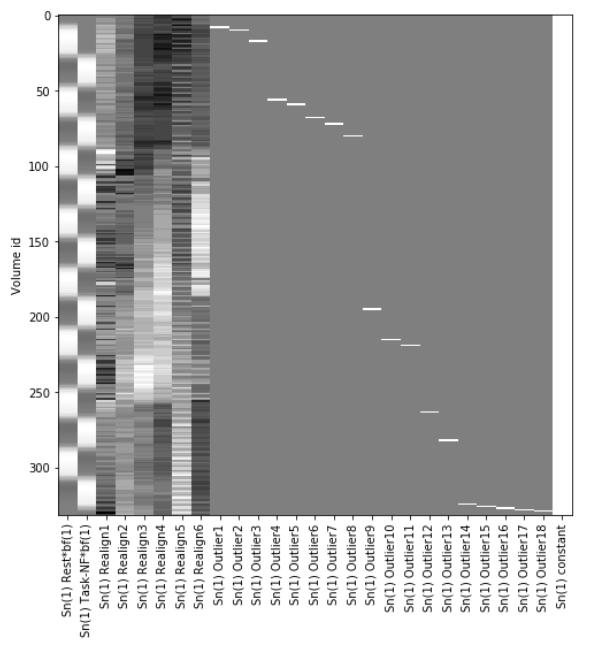

In [7]:
from IPython.display import Image
Image(filename='GLM.png',width=600, height=500)

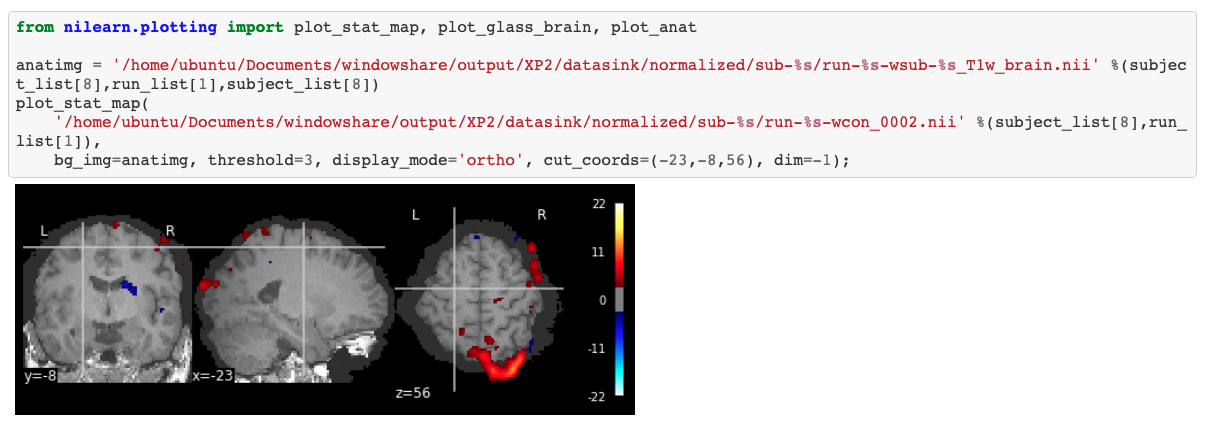

In [12]:
Image(filename='individual01.png',width=1100, height=400)

##fMRI 2 Level (Group) Analysis

##Threshold

In [ ]:
# TO RUN ONLY ONCE TO EXTRACT GRAY MATTER MASK

%%bash
TEMPLATE='/home/ubuntu/Documents/MATLAB/spm12/tpm/TPM.nii'

# Extract the first volume with `fslroi`
fslroi $TEMPLATE GM_PM.nii.gz 0 1

# Threshold the probability mask at 10%
fslmaths GM_PM.nii -thr 0.10 -bin /home/ubuntu/Documents/windowshare/output/XP2/datasink/GM_mask.nii.gz

# Unzip the mask and delete the GM_PM.nii file
gunzip /home/ubuntu/Documents/windowshare/output/XP2/datasink/GM_mask.nii.gz
rm GM_PM.nii.gz

##Layers

In [ ]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='spm_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

#Connect the layers

In [ ]:
# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id'),
                                               ('task_id','task_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

In [ ]:
l2analysis.run()